In [1]:
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax import random, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive

import tinygp
from tinygp import kernels
from tinygp import GaussianProcess

import matplotlib.pyplot as plt
from corner import corner

from functools import partial
# numpyro.enable_x64()

In [32]:
df = pd.read_hdf('/Users/ajl573/OneDrive/Data/alexlyttle/gyraffe/data.hdf5')
df["log_tau_he"] = np.log10(df["tau_he"])
df["log_tau_cz"] = np.log10(df["tau_cz"])
df['delta_tau'] = df['log_tau_cz'] / df['log_tau_he']
m = 0.08/3
df['flag'] = df['delta_tau'] - (6*m + 1. - m * df['log_tau_he']) < 0
df["log_nu_max"] = np.log10(df["nu_max"])
df.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,tau_he,delta_he,amp_he,tau_cz,dirname,log_tau_he,log_tau_cz,delta_tau,flag,log_nu_max
0,profile4,152.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,15247.850269,2037.139686,0.029961,38796.631185,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.183209,4.588794,1.096956,False,2.204462
1,profile5,153.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14809.891105,1980.528826,0.029540,37900.327592,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.170552,4.578643,1.097851,False,2.217565
2,profile6,154.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14496.838617,1940.585790,0.029221,37222.634389,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.161273,4.570807,1.098416,False,2.227690
3,profile7,155.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14220.559706,1878.217087,0.028561,36703.539749,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.152917,4.564708,1.099157,False,2.235572
4,profile8,156.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14054.932771,1883.449431,0.028860,36302.082709,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.147829,4.559932,1.099354,False,2.241746


In [33]:
# idx = 1
idx = df.loc[(df["frac_age"] > .01) & (df["frac_age"] < 1.0) & (df["effective_T"] < 6000.)].sample(1, random_state=0).index[0]
df.loc[idx]

filename         profile692
model_number          840.0
evol_stage              1.0
initial_mass            0.8
initial_Yinit          0.28
                    ...    
log_tau_he         2.892073
log_tau_cz         3.401387
delta_tau          1.176107
flag                  False
log_nu_max         3.516642
Name: 14821, Length: 120, dtype: object

In [36]:
star = df.loc[idx]

In [37]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)

nu_max_true = df.loc[idx, "nu_max"]
nu_max_err = 0.01 * nu_max_true
nu_max = nu_max_true + nu_max_err * random.normal(key)

In [38]:
rng, key = random.split(rng)

num_orders = 20
min_order = 10
n = np.arange(min_order, min_order + num_orders)
n_pred = np.linspace(n.min(), n.max(), 101)

nu_cols = [f"nu_0_{i}" for i in n]
nu_true = df.loc[idx, nu_cols].astype(float).to_numpy()
nu_err = 0.8 * (nu_true - nu_max_true)**2 / nu_max_true**2 + 0.01
nu = nu_true + nu_err * random.normal(key, shape=(num_orders,))

In [39]:
rng, key = random.split(rng)

# delta_nu_true = df.loc[idx, "delta_nu_fit"]
i_max = np.argmin((nu_true - nu_max_true)**2)
delta_nu_true = np.diff(nu_true[i_max-3:i_max+3]).mean()
delta_nu_err = 0.1
delta_nu = delta_nu_true + delta_nu_err * random.normal(key)

In [40]:
del df

In [41]:
path = "/Volumes/daviesgr-cartography/mesa_grid/grid2p5_zams_rgb_ov/grid_2p5"

In [42]:
import zipfile, os
import gyraffe
from gyraffe.io import read_mesa_profile

In [43]:
idx = 0
archive_name = os.path.join(path, star["dirname"], "GYRE.zip")

In [44]:
with zipfile.ZipFile(archive_name, 'r') as archive:
#     print(archive.namelist()[0])
    with archive.open(os.path.join(star["dirname"], star["filename"] + ".data.GYRE")) as file:
#         for i in range(10):
#             print(file.readline())}
        profile = read_mesa_profile(file)

In [45]:
profile["c"] = gyraffe.sound_speed(profile)
profile["tau"] = gyraffe.acoustic_depth(profile)
profile.head()

,k,r,M_r,L_r,P,T,rho,nabla,N^2,Gamma_1,...,delta,kap,kap kap_T,kap kap_rho,eps_nuc,eps_nuc*eps_T,eps_nuc*eps_rho,Omega_rot,c,tau
0,1,0.000000e+00,0.000000e+00,0.000000e+00,3.877624e+17,1.595453e+07,348.069974,0.225765,0.000000e+00,1.667192,...,0.929390,2.120666,-4.950497,0.759437,4.508144,72.059092,4.973878,0.0,4.309654e+07,3562.817205
1,2,4.401672e+07,1.243316e+26,5.610462e+26,3.877313e+17,1.595424e+07,348.036958,0.225786,9.544342e-09,1.667192,...,0.929395,2.120704,-4.950525,0.759455,4.508735,72.064934,4.974482,0.0,4.309685e+07,3561.795857
2,3,5.545821e+07,2.486632e+26,1.122144e+27,3.877109e+17,1.595406e+07,348.016211,0.225798,1.253045e-08,1.667192,...,0.929398,2.120730,-4.950546,0.759467,4.508937,72.066433,4.974681,0.0,4.309701e+07,3561.530375
3,4,6.987417e+07,4.973263e+26,2.244331e+27,3.876792e+17,1.595376e+07,347.986922,0.225804,1.873267e-08,1.667192,...,0.929402,2.120770,-4.950591,0.759488,4.508892,72.062426,4.974586,0.0,4.309706e+07,3561.195875
4,5,8.803832e+07,9.946527e+26,4.488681e+27,3.876291e+17,1.595329e+07,347.939962,0.225809,2.917273e-08,1.667192,...,0.929409,2.120834,-4.950660,0.759521,4.508830,72.056855,4.974453,0.0,4.309718e+07,3560.774404


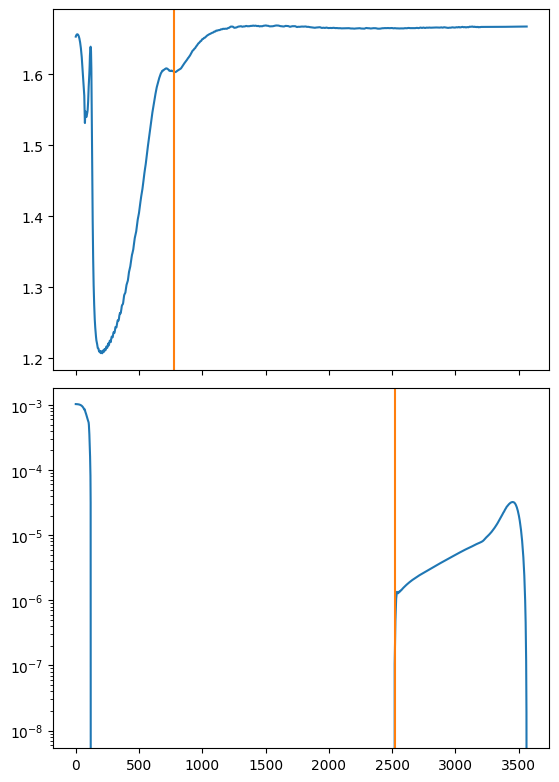

In [47]:
tau_he = 10**star["log_tau_he"]
tau_cz = 10**star["log_tau_cz"]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 9.6),
                               sharex=True, gridspec_kw={"hspace": 0.05})

ax1.plot(profile["tau"], profile["Gamma_1"])
ax1.axvline(tau_he, color="C1", label="tau_he")
# ax1.axvspan(
#     tau_he_low, tau_he_high,
#     alpha=0.2,
#     facecolor="C1"
# )


# ax1.axvspan(
#     profile.loc[profile["T"] > 2e4, "tau"].iloc[-1],
#     profile.loc[profile["T"] < 2e5, "tau"].iloc[0],
#     facecolor="none",
#     edgecolor="C2",
#     hatch="//",
#     label="2e4 < T/K < 2e5"
# )
# ax1.legend()
# # ax1.grid(True)
ax2.plot(profile["tau"], profile["N^2"])
ax2.axvline(tau_cz, color="C1", label="tau_cz")
# ax2.axvspan(
#     tau_cz_low, tau_cz_high,
#     alpha=0.2,
#     facecolor="C1"
# )
ax2.set_yscale("log")
# ax2.legend();

In [48]:
import jaxns
from jaxns import NestedSampler

In [49]:
from jax.scipy.stats import norm, multivariate_normal

class Distribution:
    def __init__(self, name):
        self.name = name

    def jaxns_dist(self):
        raise NotImplementedError()

    def numpyro_dist(self):
        raise NotImplementedError()

    def log_probability(self, x):
        raise NotImplementedError()
    
    def sample(self, key, shape=()):
        raise NotImplementedError()
    
    def prior_chain(self):
        with jaxns.PriorChain() as _prior_chain:
            _ = self.jaxns_dist()
        return _prior_chain


class Normal(Distribution):
    def __init__(self, name, loc=0.0, scale=1.0):
        super().__init__(name)
        self.loc = loc
        self.scale = scale
    
    def jaxns_dist(self):
        return jaxns.NormalPrior(self.name, self.loc, self.scale)
    
    def log_probability(self, x):
        return norm.logpdf(x, loc=self.loc, scale=self.scale)
    
    def sample(self, key, shape=()):
        return self.loc + self.scale * random.normal(key, shape=shape)


class LogNormal(Distribution):
    def __init__(self, name, loc=0.0, scale=1.0):
        super().__init__(name)
        self.loc = loc
        self.scale = scale
    
    def jaxns_dist(self):
        return jaxns.LogNormalPrior(self.name, self.loc, self.scale)

    def log_probability(self, x):
        return norm.logpdf(jnp.log(x), loc=self.loc, scale=self.scale)

    def sample(self, key, shape=()):
        return jnp.exp(self.loc + self.scale * random.normal(key, shape=shape))


class Uniform(Distribution):
    def __init__(self, name, low=0.0, high=1.0):
        super().__init__(name)
        self.low = low
        self.high = high
    
    def jaxns_dist(self):
        return jaxns.UniformPrior(self.name, self.low, self.high)
    
    def log_probability(self, x):
        return jnp.log(1.0) - jnp.log(self.high - self.low)

    def sample(self, key, shape=()):
        return self.low + (self.high - self.low) * random.uniform(key, shape=shape)


class JointDistribution(Distribution):
    """
    Takes distributions, an iterable of Distributions or callables which
    return distributions.
    
    Example:

        distributions = [
            Normal("a"),
            Normal("b"),
            lambda a, b: Normal("c", a)
        ]
        joint_dist = JointDistribution("joint_dist", distributions)

    """
    def __init__(self, name, distributions):
        super().__init__(name)
        self.distributions = distributions

    def jaxns_dist(self):
        params = []
        for fn in self.distributions:
            if isinstance(fn, Distribution):
                params.append(fn.jaxns_dist())
            elif callable(fn):
                params.append(fn(*params).jaxns_dist())
        return params

    def log_probability(self, **x):
#     def log_probability(self, x):
        params = x.copy()
        logp = 0.0
        for fn in self.distributions[::-1]:
            # Loop through distributions in reverse
            if isinstance(fn, Distribution):
                logp += fn.log_probability(params.pop(fn.name))
            elif callable(fn):
                logp += fn(*params.values()).log_probability(params.pop(fn.name))
        return logp
    
    def sample(self, key, shape=()):
        samples = {}
        keys = random.split(key, len(self.distributions))
        for k, fn in zip(keys, self.distributions):
            if isinstance(fn, Distribution):
                samples[fn.name] = fn.sample(k, shape=shape)
            elif callable(fn):
                d = fn(*params.values())
                samples[d.name] = d.sample(k, shape=shape)
        return samples

# class _GaussianProcess(Distribution):
#     """Wrapper for tinygp Gaussian process to work with Distribution"""
#     def __init__(self, name, *args, **kwargs):
#         # first argument is reserved for name
#         super().__init__(name)

# class NewGaussianProcess(GaussianProcess, Distribution):
#     def __init__(self, name, *args, **kwargs):
#         self.name = name
#         super().__init__(*args, **kwargs)
    
#     def jaxns_dist(self):
#         return jaxns.MVNPrior(self.name, self.mean, self.covariance)

class MVNormal(Distribution):
    """Wrapper for tinygp Gaussian process which inherits Distribution."""
    def __init__(self, name, loc, cov):
        # first argument is reserved for name
        super().__init__(name)
        self.loc = loc
        self.covariance = cov

    def jaxns_dist(self):
        return MVNPrior(self.name, self.loc, self.cov)

    def sample(self, key, shape=()):
        return random.multivariate_normal(key, self.loc, self.cov, shape=shape)

    def log_probability(self, x):
        return multivariate_normal.logpdf(x, self.loc, self.cov)

In [50]:
# class Glitch(Distribution):
#     """The probability of nu.
    
#     """
#     def __init__(self, *, delta_nu, epsilon, a_he, b_he, tau_he, phi_he,
#                  a_cz, tau_cz, phi_cz, kernel_amp, kernel_scale, diag=None):
#         self.delta_nu = delta_nu
#         self.epsilon = epsilon
#         self.a_he = a_he
#         self.b_he = b_he
#         self.tau_he = tau_he
#         self.phi_he = phi_he
#         self.a_cz = a_cz
#         self.tau_cz = tau_cz
#         self.phi_cz = phi_cz
#         self.kernel_amp = kernel_amp
#         self.kernel_scale = kernel_scale
#         self.diag = diag
                
#     def asymptotic(self, n):
#         return self.delta_nu * (n + self.epsilon)
    
#     @staticmethod
#     def _oscillation(nu, *, tau, phi):
#         return jnp.sin(4 * jnp.pi * tau * nu + phi)
    
#     def heII_amplitude(self, nu):
#         return self.a_he * nu * jnp.exp(- self.b_he * nu**2)
    
#     def heII_glitch(self, nu):
#         osc = self._oscillation(nu, tau=self.tau_he, phi=self.phi_he)
#         return self.heII_amplitude(nu) * osc

#     def bcz_amplitude(self, nu):
#         return self.a_cz / nu**2
    
#     def bcz_glitch(self, nu):
#         osc = self._oscillation(nu, tau=self.tau_cz, phi=self.phi_cz)
#         return self.bcz_amplitude(nu) * osc
    
#     def mean(self, n):
#         nu_asy = self.asymptotic(n)
#         dnu_he = self.heII_glitch(nu_asy)
#         dnu_cz = self.bcz_glitch(nu_asy)
#         return nu_asy + dnu_he + dnu_cz
    
#     @property
#     def kernel(self):
#         return self.kernel_amp * kernels.ExpSquared(self.kernel_scale)
    
#     def build_gp(self, n, **kwargs):
#         return GaussianProcess(self.kernel, n, mean=self.mean, **kwargs)
class Asy:
    def __init__(self, *, delta_nu, epsilon, kernel_amp, kernel_scale):
        self.delta_nu = delta_nu
        self.epsilon = epsilon
        self.kernel_amp = kernel_amp
        self.kernel_scale = kernel_scale  
#         self.nu_max = nu_max
#         self.curv = curv
                
    def asymptotic(self, n):
#         n_max = self.nu_max / self.delta_nu - self.epsilon
        return self.delta_nu * (n + self.epsilon)  # + self.curv * (n - n_max)**2) 
    
    def mean(self, n):
        return self.asymptotic(n)
    
    @property
    def kernel(self):
        return self.kernel_amp * kernels.ExpSquared(self.kernel_scale)
    
    def build_gp(self, n, **kwargs):
        return GaussianProcess(self.kernel, n, mean=self.mean, **kwargs)


class Glitch:
    def __init__(self, *, delta_nu, epsilon, a_he, b_he, tau_he, phi_he,
                 a_cz, tau_cz, phi_cz, kernel_amp, kernel_scale):
        self.delta_nu = delta_nu
        self.epsilon = epsilon
        self.a_he = a_he
        self.b_he = b_he
        self.tau_he = tau_he
        self.phi_he = phi_he
        self.a_cz = a_cz
        self.tau_cz = tau_cz
        self.phi_cz = phi_cz
        self.kernel_amp = kernel_amp
        self.kernel_scale = kernel_scale  
#         self.nu_max = nu_max
#         self.curv = curv
                
    def asymptotic(self, n):
#         n_max = self.nu_max / self.delta_nu - self.epsilon
        return self.delta_nu * (n + self.epsilon)  # + self.curv * (n - n_max)**2) 

    @staticmethod
    def _oscillation(nu, *, tau, phi):
        return jnp.sin(4 * jnp.pi * tau * nu + phi)
    
    def heII_amplitude(self, nu):
        return self.a_he * nu * jnp.exp(- self.b_he * nu**2)
    
    def heII_glitch(self, nu):
        osc = self._oscillation(nu, tau=self.tau_he, phi=self.phi_he)
        return self.heII_amplitude(nu) * osc

    def bcz_amplitude(self, nu):
        return self.a_cz / nu**2
    
    def bcz_glitch(self, nu):
        osc = self._oscillation(nu, tau=self.tau_cz, phi=self.phi_cz)
        return self.bcz_amplitude(nu) * osc
    
    def mean(self, n):
        nu_asy = self.asymptotic(n)
#         return nu_asy
        dnu_he = self.heII_glitch(nu_asy)
        dnu_cz = self.bcz_glitch(nu_asy)
        return nu_asy + dnu_he + dnu_cz
    
    @property
    def kernel(self):
        return self.kernel_amp * kernels.ExpSquared(self.kernel_scale)
#         return self.kernel_amp * kernels.RationalQuadratic(self.kernel_scale, alpha=1.0)
    
    def build_gp(self, n, **kwargs):
        return GaussianProcess(self.kernel, n, mean=self.mean, **kwargs)


class GlitchModel:
    """Model which predicts nu given n, prior and nu_err.
    
    """
    def __init__(self, n, nu_err=None):
        # TODO:
        self.n = n
#         self.prior = prior
        self.nu_err = nu_err

    @property
    def nu_err(self):
        return self._nu_err
    
    @nu_err.setter
    def nu_err(self, value):
        if value is not None:
            value = jnp.array(value)
            assert value.shape == () or value.shape == self.n.shape
        self._nu_err = value

    @property
    def diag(self):
        return None if self.nu_err is None else self.nu_err**2

#     def prior_chain(self):
#         with jaxns.PriorChain() as prior_chain:
#             _ = self.prior.jaxns_dist()
#         return prior_chain
    
#     def log_prior(self, *, delta_nu, epsilon, kernel_amp, kernel_scale,
#                   a_he, b_he, tau_he, phi_he, a_cz, tau_cz, phi_cz):
#         """P(model)"""
#         return self.prior.log_probability(
#             delta_nu=delta_nu, epsilon=epsilon, kernel_amp=kernel_amp,
#             kernel_scale=kernel_scale, a_he=a_he,
#             b_he=b_he, tau_he=tau_he, phi_he=phi_he,
#             a_cz=a_cz, tau_cz=tau_cz, phi_cz=phi_cz
#         )
#         return self.prior.log_probability(params)
    
    def log_likelihood(self, nu):
        """P(data | model)"""
        def _log_likelihood(*, delta_nu, epsilon, kernel_amp, kernel_scale,
                            a_he, b_he, tau_he, phi_he, a_cz, tau_cz, phi_cz):

            glitch = Glitch(delta_nu=delta_nu, epsilon=epsilon, kernel_amp=kernel_amp,
                            kernel_scale=kernel_scale, a_he=a_he,
                            b_he=b_he, tau_he=tau_he, phi_he=phi_he,
                            a_cz=a_cz, tau_cz=tau_cz, phi_cz=phi_cz)

            gp = glitch.build_gp(self.n, diag=self.diag)
#             dnu_he = glitch.heII_glitch(nu)
#             dnu_cz = glitch.bcz_glitch(nu)
            return gp.log_probability(nu)
#             return gp.log_probability(nu - dnu_he - dnu_cz)

        return _log_likelihood
    
    def sample(self, key, params, nu=None, shape=None):
        """Sample the prior predictive for nu given params"""
        # TODO: separate predictive from making predictions at new n
#         samples = {}
        glitch = Glitch(**params)
        gp = glitch.build_gp(self.n, diag=self.diag)
        
#         if nu is None:
#             nu = gp.sample(key, shape=shape)
#         dnu_he = glitch.heII_glitch(nu)
#         dnu_cz = glitch.bcz_glitch(nu)
#         return nu + dnu_he + dnu_cz
        return gp.sample(key, shape=shape)
        

#         if nu is None:
#             # Could just replace this with gp.sample(...)?
#             samples["nu"] = random.multivariate_normal(
#                 key, 
#                 gp.mean, 
#                 gp.covariance, 
#                 shape=shape
#             )
#         else:
#             gp_pred = gp.condition(nu, self.n).gp
#             samples["nu"] = random.multivariate_normal(
#                 key, 
#                 gp_pred.mean, 
#                 gp_pred.covariance, 
#                 shape=shape
#             )

#         samples["nu_asy"] = nu_asy = glitch.asymptotic(self.n)
#         samples["dnu_he"] = glitch.heII_glitch(nu_asy)
#         samples["dnu_cz"] = glitch.bcz_glitch(nu_asy)

#         return samples

    def predict(self, key, params, *, n, nu=None, shape=None):
        # TODO: separate predictive from making predictions at new n
        samples = {}

        glitch = Glitch(**params)
        gp = glitch.build_gp(self.n, diag=self.diag)
        
#         nu = self.nu
        if nu is None:
            key, other_key = random.split(key)
#             nu = random.multivariate_normal(
#                 other_key,
#                 gp.mean, 
#                 gp.covariance, 
#                 shape=shape
#             )
            nu = gp.sample(other_key, shape=shape)

        gp_pred = gp.condition(nu, n).gp
        
        key, other_key = random.split(key)
        samples["nu"] = random.multivariate_normal(
            other_key,
            gp_pred.mean,
            gp_pred.covariance,
            shape=shape
        )
#         samples["_nu"] = random.multivariate_normal(
#             other_key,
#             gp_pred.mean,
#             gp_pred.covariance,
#             shape=shape
#         )
        
        samples["nu_asy"] = nu_asy = glitch.asymptotic(n)
        samples["dnu_he"] = glitch.heII_glitch(nu_asy)
        samples["dnu_cz"] = glitch.bcz_glitch(nu_asy)
#         samples["dnu_he"] = glitch.heII_glitch(samples["_nu"])
#         samples["dnu_cz"] = glitch.bcz_glitch(samples["_nu"])
#         samples["nu"] = samples["_nu"] + samples["dnu_he"] + samples["dnu_cz"]
        return samples
    
    def plot_echelle(self, key, samples, *, n, nu=None, delta_nu=None, num_draws=100, ax=None):
        if delta_nu is None:
            delta_nu = samples["delta_nu"].mean()

        keys = random.split(key)
        subsamples = jax.tree_map(partial(random.choice, keys[0], shape=(num_draws,), replace=False), samples)

        keys = random.split(keys[1], num_draws)
        pred = vmap(partial(self.predict, n=n, nu=nu))(keys, subsamples)

        if ax is None:
            _, ax = plt.subplots()

        y = (pred["nu"] - n_pred * delta_nu) % delta_nu
        
        log_likelihood = self.log_likelihood(pred["nu"])
        
        lines = ax.plot(y.T, pred["nu"].T, "k", alpha=0.33, label="model")
        handles = [lines[0]]

        if nu is not None:
            y_obs = nu % delta_nu
            if self.nu_err is None:
                obs, = ax.plot(y_obs, nu, "o", label="observed")
            else:
                obs = ax.errorbar(y_obs, nu, xerr=self.nu_err, fmt="o", label="observed")
            handles.append(obs)

        ax.set_ylabel("frequency (uHz)")
        ax.set_xlabel(f"frequency modulo {delta_nu:.2f} (uHz)")
        ax.legend(handles=handles)
        return ax
    
    
    def plot_glitch(self, key, samples, *, n, nu=None, kind="he", num_draws=100, ax=None):
        keys = random.split(key, 3)
        subsamples = jax.tree_map(partial(random.choice, keys[0], shape=(num_draws,), replace=False), samples)

        _keys = random.split(keys[1], num_draws)
        pred = vmap(partial(self.predict, n=n))(_keys, subsamples)
        
        if ax is None:
            _, ax = plt.subplots()

        dnu = pred[f"dnu_{kind}"]
        lines = ax.plot(pred["nu"].T, dnu.T, "k", alpha=0.33, label="model")
        handles = [lines[0]]

        if nu is not None:
            _keys = random.split(keys[2], num_draws)
            obs_pred = vmap(partial(self.predict, n=self.n, nu=nu))(_keys, subsamples)
            res = nu - obs_pred["nu"]
            dnu_obs = obs_pred[f"dnu_{kind}"] + res
            if nu_err is None:
                obs, = ax.plot(nu, dnu_obs.mean(axis=0), "o", label="observed")
            else:
                obs = ax.errorbar(nu, dnu_obs.mean(axis=0), yerr=self.nu_err, fmt="o", label="observed")
            handles.append(obs)
            # plot the obs - model

        ax.set_xlabel("frequency (uHz)")
        ax.set_ylabel("glitch frequency (uHz)")
        ax.legend(handles=handles)
        return ax

Text(0.5, 1.0, 'exponential squared')

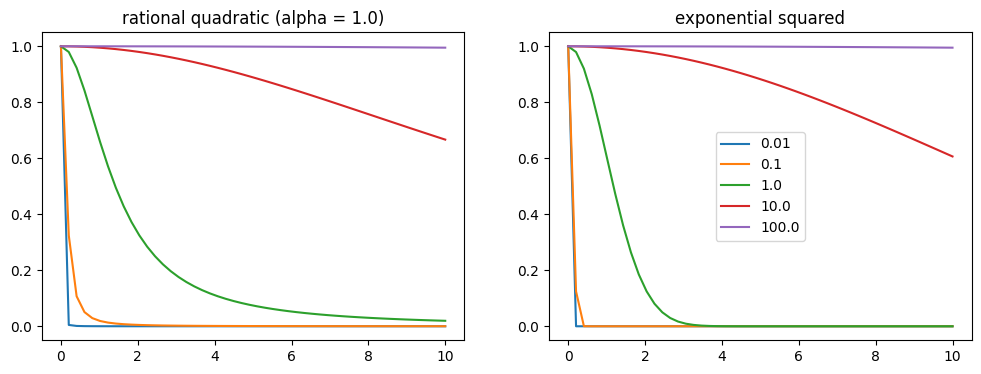

In [52]:
scales = jnp.logspace(-2, 2, 5)
x = jnp.linspace(0.0, 10.0)

k0 = vmap(lambda s: kernels.RationalQuadratic(scale=s, alpha=1.0)(x, x)[0])(scales)
k1 = vmap(lambda s: kernels.ExpSquared(scale=s)(x, x)[0])(scales)


xp = np.broadcast_to(x, k0.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(xp.T, k0.T, label=scales)
axes[0].set_title("rational quadratic (alpha = 1.0)")

axes[1].plot(xp.T, k1.T, label=scales)
axes[1].legend()
axes[1].set_title("exponential squared")

In [79]:
def log_likelihood(params):
    p = params.copy()
    glitch_kernel = jnp.exp(p.pop("log_amp")) \
        * kernels.ExpSineSquared(jnp.exp(p.pop("log_period")), gamma=jnp.exp(p.pop("log_gamma")))  # pi/P is the period
    asy = Asy(**p)
    gp = GaussianProcess(asy.kernel + glitch_kernel, n, mean=asy.mean)
    return gp.log_probability(nu_true)

In [125]:
import jaxopt

In [126]:
from jax.scipy.stats import norm

In [127]:
@jit
def loss(params):
    return - log_likelihood(params)

In [106]:
init_params = {
    "delta_nu": delta_nu,
    "epsilon": 1.4,
    "kernel_amp": 0.1*delta_nu,
    "kernel_scale": 4.0,
    "log_tau_he": 
#     "var": 0.5,
#     "log_amp": np.log(0.01*delta_nu),
#     "log_period": np.log(1/10**(-7.0)),
#     "log_gamma": np.log(1.0),
}

In [107]:
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_util.tree_map(jnp.asarray, init_params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 9.734907150268555


In [108]:
# var = p.pop("var")
p = soln.params.copy()
glitch_kernel = jnp.exp(p.pop("log_amp")) \
        * kernels.ExpSineSquared(jnp.exp(p.pop("log_period")), gamma=jnp.exp(p.pop("log_gamma")))  # pi/P is the period
asy = Asy(**p)
gp = GaussianProcess(asy.kernel + glitch_kernel, n, mean=asy.mean)
_, cond = gp.condition(nu_true, n_pred)

In [122]:
soln.params

{'delta_nu': DeviceArray(138.53772, dtype=float32),
 'epsilon': DeviceArray(1.4198204, dtype=float32),
 'kernel_amp': DeviceArray(14.373132, dtype=float32),
 'kernel_scale': DeviceArray(2.2785127, dtype=float32),
 'log_amp': DeviceArray(-2.1882625, dtype=float32),
 'log_gamma': DeviceArray(3.7096142e-11, dtype=float32),
 'log_period': DeviceArray(16.118095, dtype=float32)}

In [123]:
np.pi/np.exp(16.11)

3.167129118850628e-07

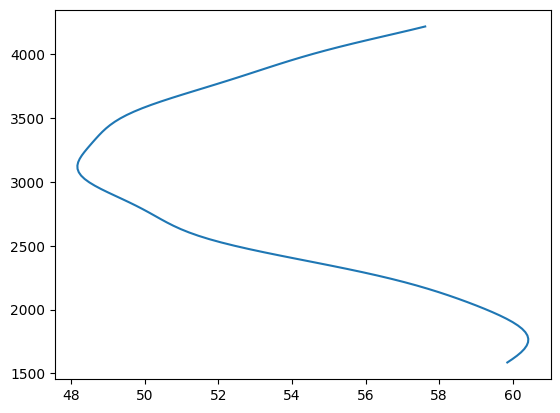

In [109]:
x = (cond.mean - n_pred * popt["delta_nu"]) % popt["delta_nu"]
plt.plot(x, cond.mean);

How I want it to work

```python
log_likelihood = GlitchLikelihood(n, nu, nu_err=nu_err)
prior_chain = GlitchPrior(delta_nu, nu_max)

ns = NestedSampler(...)
```

In [22]:
# class Inference:
#     def __init__(self, model, prior, observed):
#         self.model = model
#         self.prior = prior
#         self._observed = observed
        
#         log_likelihood = self.model.log_likelihood_fn(**self.observed)
#         prior_chain = self.prior.prior_chain()
#         self.ns = NestedSampler(log_likelihood, prior_chain)
    
#     def prior_predictive(self, key, num_samples):
#         key, new_key = random.split(key)
#         samples = prior.sample(new_key, shape=(num_samples,))
        
#         keys = random.split(key, num_samples)
#         return samples, vmap(self.model.sample)(keys, samples)
        
#     def run(self, key, *args, **kwargs):
#         jit(ns)(key, *args, **kwargs)
    
#     def posterior_predictive(self, key, samples):
#         keys = random.split(key, num_samples)
#         return vmap(self.model.sample)(keys, samples)    
    

In [157]:
# TODO: a class which automates this for given properties such as nu_max and teff.
# E.g. could work out the probability of glitch params given a value of log_g and teff
# log_g can come from nu_max and teff. This could come from a GP or other fit
prior = JointDistribution(
    "prior",
    [
        Normal("delta_nu", delta_nu, delta_nu_err),
#         Normal("nu_max", nu_max, nu_max_err),
        Normal("epsilon", 1.4, 0.1),
#         LogNormal("curv", -6.5, 0.5),
        LogNormal("kernel_amp", 2.0, 0.5),
        LogNormal("kernel_scale", 1.2, 0.5),
#         LogNormal("kernel_amp", np.log(27.0), 0.05),
#         LogNormal("kernel_scale", np.log(5.0), 0.05),
#         LogNormal("kernel_amp", 2.0, 0.5),
#         LogNormal("kernel_scale", 2.0, 0.2),
        LogNormal("a_he", -9.0, 1.0),
        LogNormal("b_he", -16.0, 1.0),
        LogNormal("tau_he", np.log(tau_he*10**-6), 0.1),
        Uniform("phi_he", -jnp.pi, jnp.pi),
        LogNormal("a_cz", 10., 1.0),
        LogNormal("tau_cz", np.log(tau_cz*10**-6), 0.1),
        Uniform("phi_cz", -jnp.pi, jnp.pi),
    ]
)

In [158]:
rng = random.PRNGKey(42)
rng, key = random.split(rng)

samples = {}
num_samples = 1000
samples["prior"] = prior.sample(key, shape=(num_samples,))

In [159]:
model = GlitchModel(n)

In [160]:
def amplitude(nu, a, b):
    return a * nu * jnp.exp(- b * nu**2)

In [161]:
a = np.logspace(-7.0, -10.0, 3, base=np.e)
b = np.logspace(-17, -15.0, 3, base=np.e)
aa, bb = np.meshgrid(a, b)
A = aa.ravel()
B = bb.ravel()

nu_in = np.broadcast_to(nu_true, A.shape + nu_true.shape)
y = vmap(lambda a, b: amplitude(nu_true, a, b))(A, B)

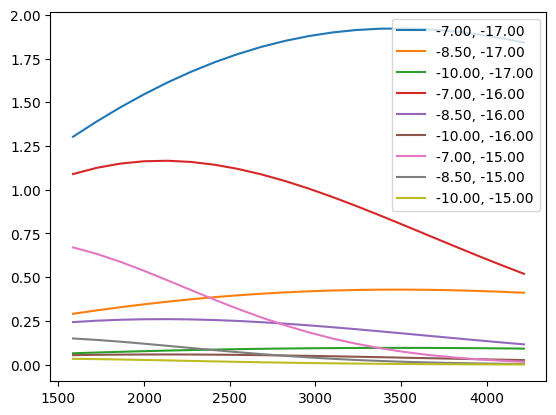

In [162]:
label = list(map(lambda t: f"{np.log(t[0]):.2f}, {np.log(t[1]):.2f}", zip(A, B)))

fig, ax = plt.subplots()

ax.plot(nu_in.T, y.T, label=label)
ax.legend();

In [163]:
# rng, key = random.split(rng)
# keys = random.split(key, num_samples)

# samples["prior_predictive"] = vmap(partial(model.predict, n=n))(keys, samples["prior"])

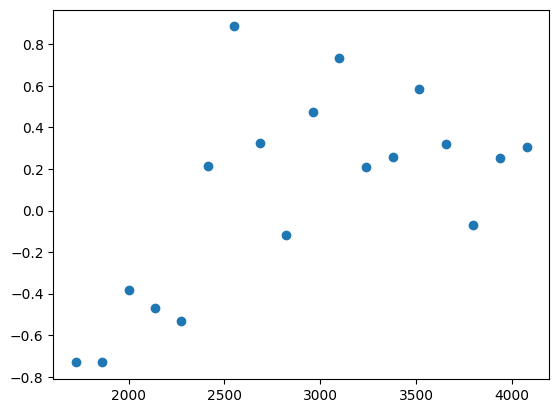

In [164]:
d2nu = nu_true[2:] - 2*nu_true[1:-1] + nu_true[:-2]
_, ax = plt.subplots()
ax.plot(nu_true[1:-1], d2nu, "o");

## To do

Build a sampling results class which is similar to the arviz inference data to contain dimension and coord information for the variables, with their symbols and units.

In [165]:
n_pred = jnp.linspace(n.min(), n.max(), 101)

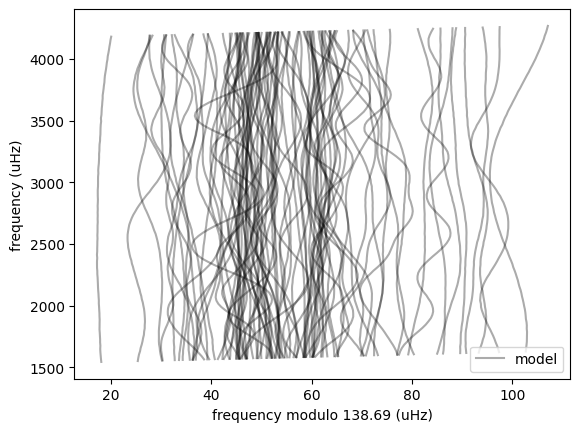

In [166]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples["prior"], n=n_pred)

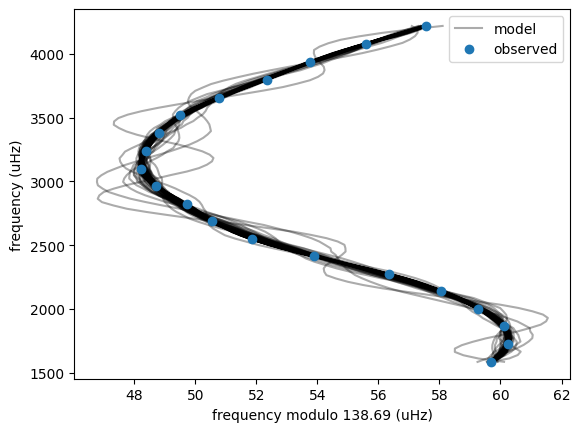

In [167]:
ax = model.plot_echelle(key, samples["prior"], n=n_pred, nu=nu)

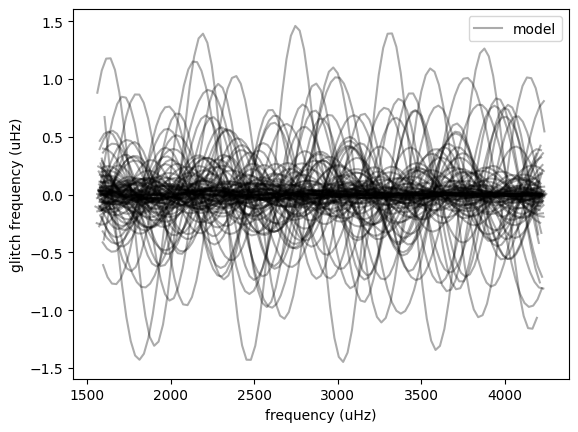

In [168]:
ax = model.plot_glitch(key, samples["prior"], n=n_pred)

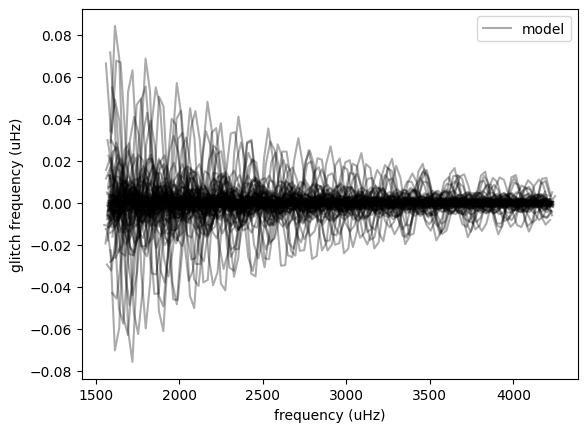

In [172]:
ax = model.plot_glitch(key, samples["prior"], n=n_pred, kind="cz")

In [173]:
# model = prior_model.condition(nu, nu_err=nu_err)
ns = NestedSampler(model.log_likelihood(nu_true), prior.prior_chain())

In [174]:
%%time
rng, key = random.split(rng)

results = jit(ns)(key=key)

CPU times: user 36.3 s, sys: 470 ms, total: 36.7 s
Wall time: 36.9 s


In [175]:
jaxns.summary(results);

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 3730840
# samples: 26400
# likelihood evals / sample: 141.3
--------
logZ=-13.79 +- 0.11
H=39.0
ESS=5974
--------
a_cz: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
a_cz: 18000.0 +- 24000.0 | 5000.0 / 10000.0 / 42000.0 | 9000.0 | 61000.0
--------
a_he: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
a_he: 0.000105 +- 5e-05 | 7.2e-05 / 9.8e-05 / 0.000135 | 8.1e-05 | 0.000114
--------
b_he: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
b_he: 8.1e-08 +- 9e-08 | 3.9e-08 / 6.4e-08 / 1.06e-07 | 3.5e-08 | 7.8e-08
--------
delta_nu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
delta_nu: 138.717 +- 0.075 | 138.604 / 138.736 / 138.788 | 138.623 | 138.707
--------
epsilon: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
epsilon: 1.393 +- 0.017 | 1.372 / 1.392 / 1.414 | 1.403 | 1.401
--------
kernel_a

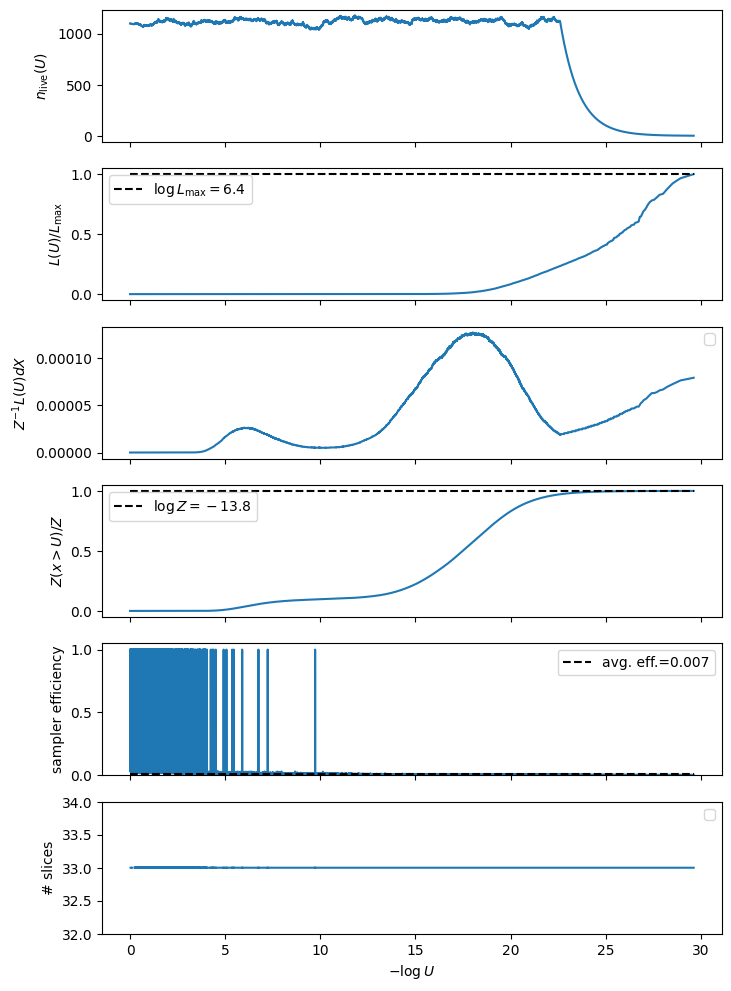

In [176]:
jaxns.plot_diagnostics(results);

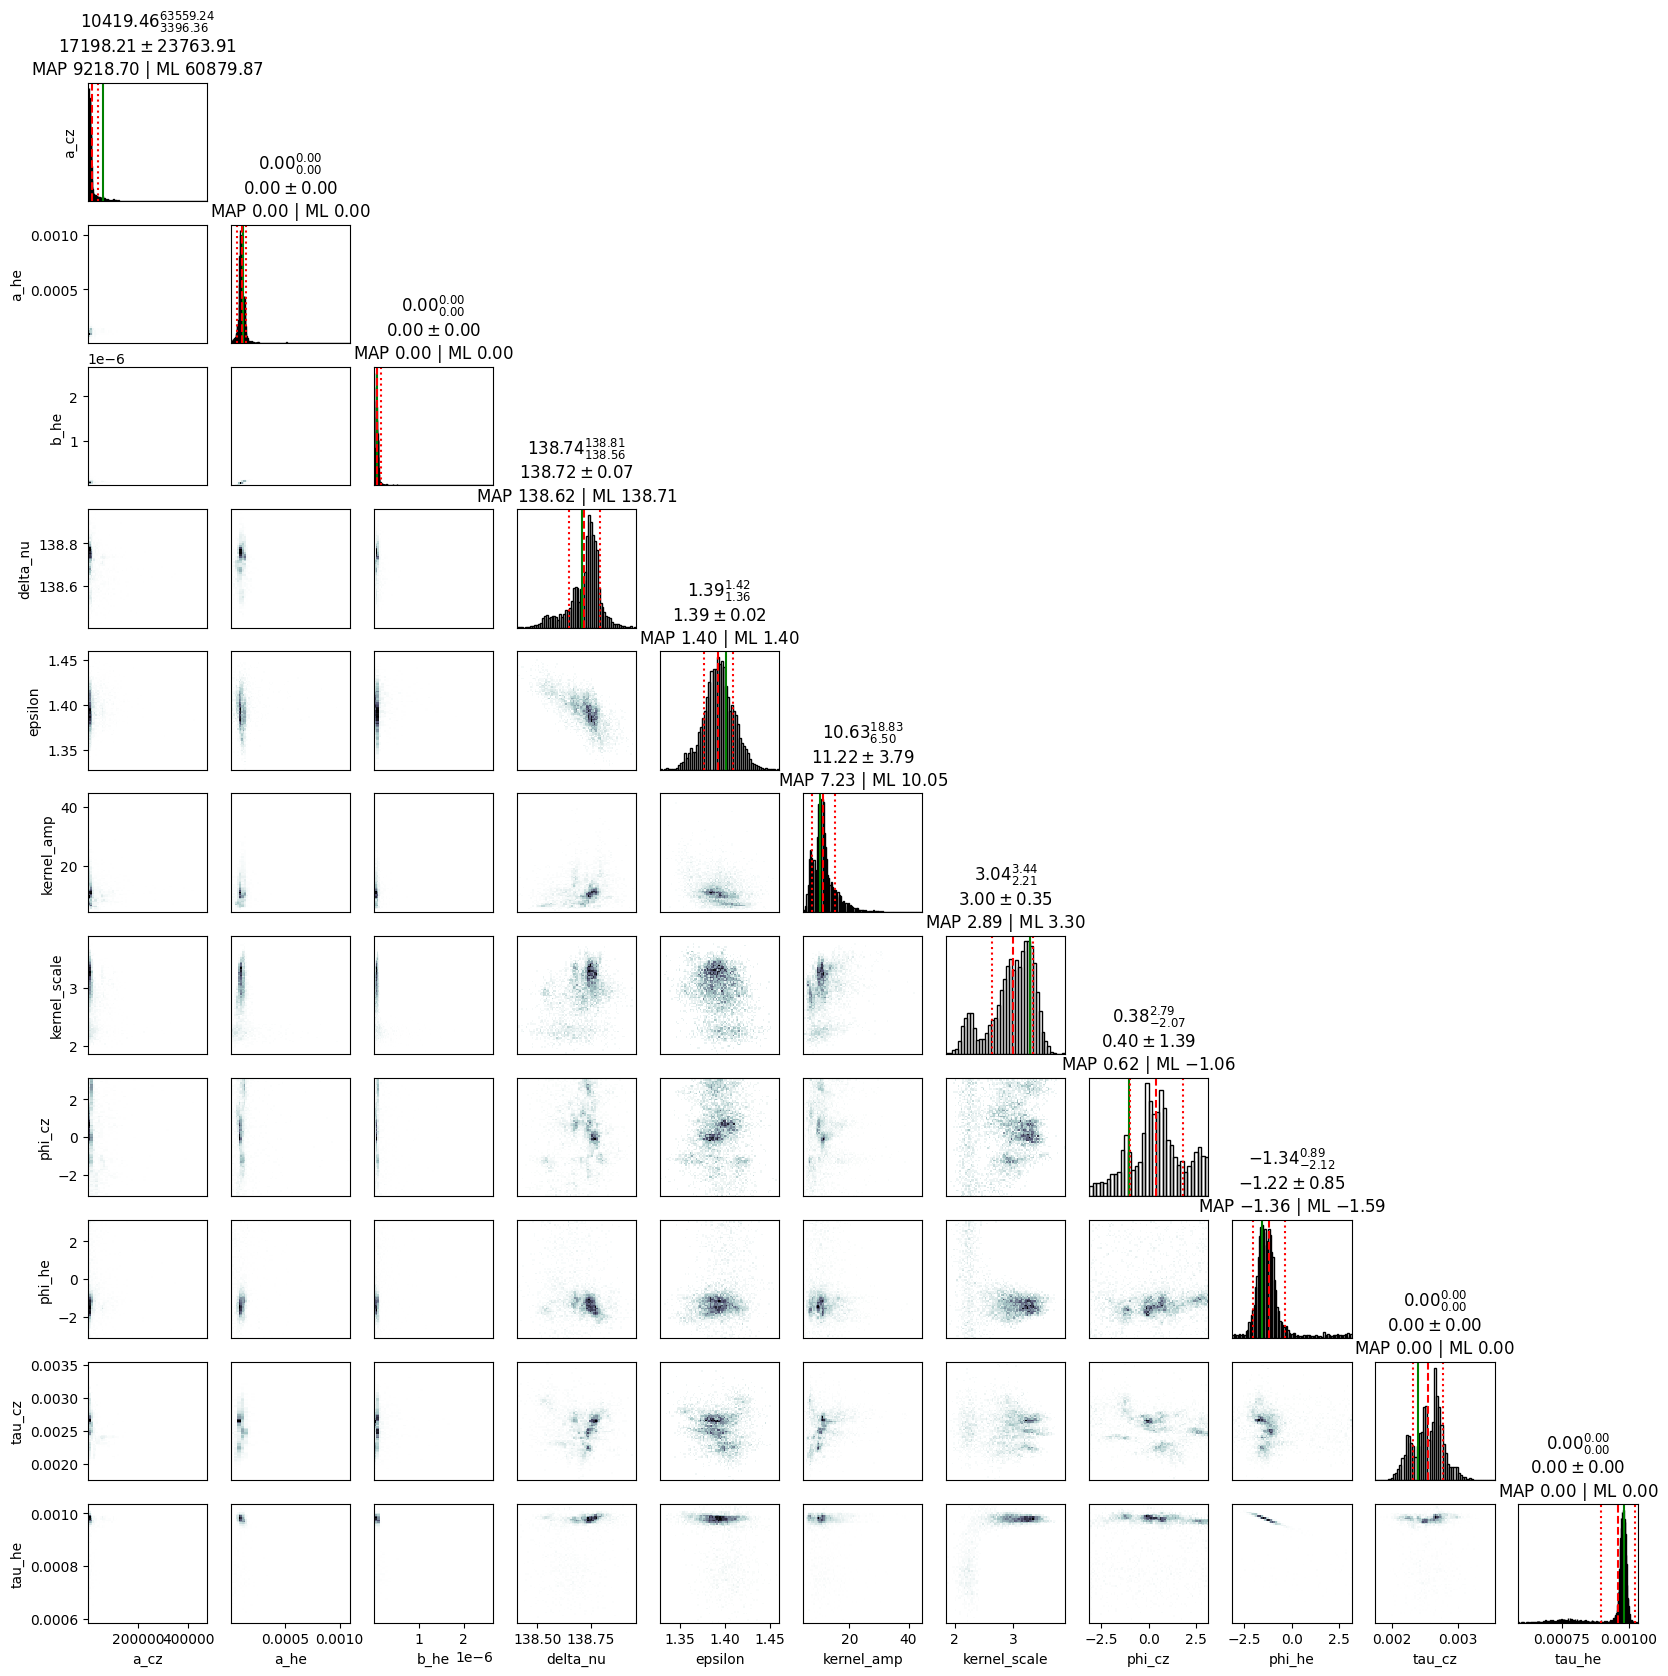

In [177]:
jaxns.plot_cornerplot(results);

In [178]:
num_samples = int(results.ESS)
rng, key = random.split(rng)
samples["posterior"] = jaxns.resample(key, results.samples, results.log_dp_mean, S=num_samples, replace=True)

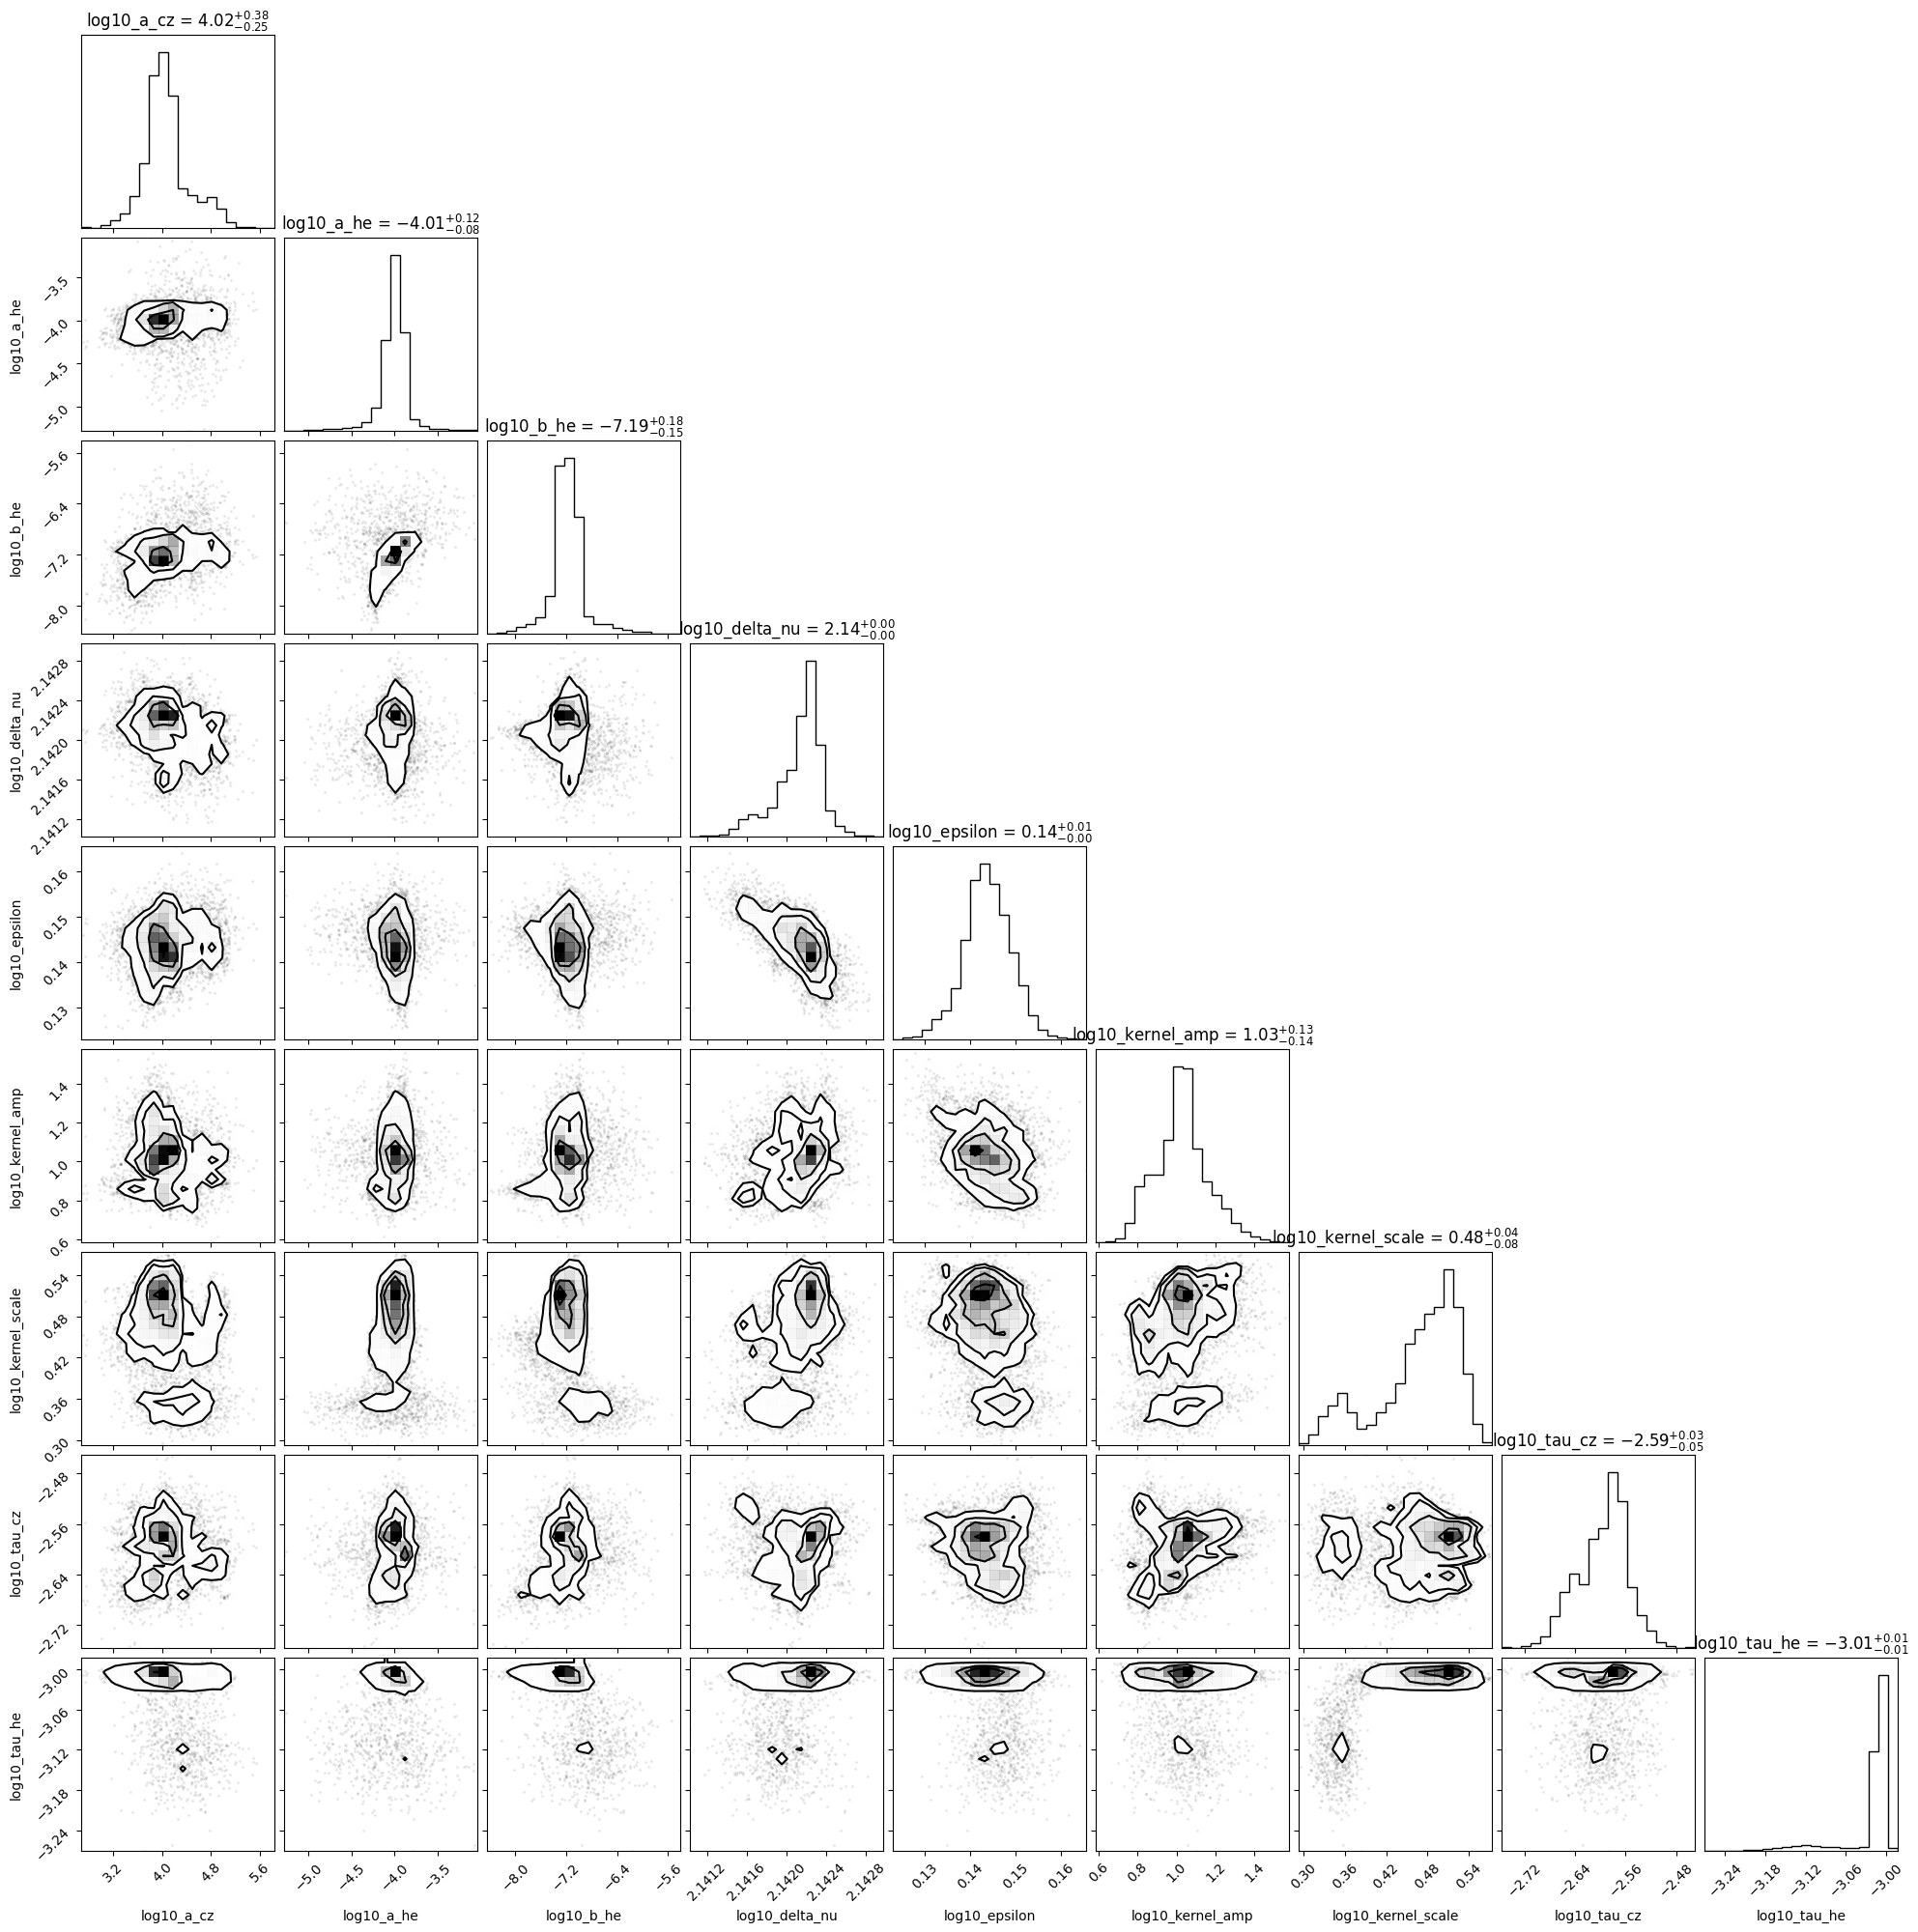

In [179]:
log_samples = jax.tree_map(
    jnp.log10,
    {"_".join(["log10", k]): v for k, v in samples["posterior"].items() if (v > 0.0).all()}
)
corner(log_samples, show_titles=True);

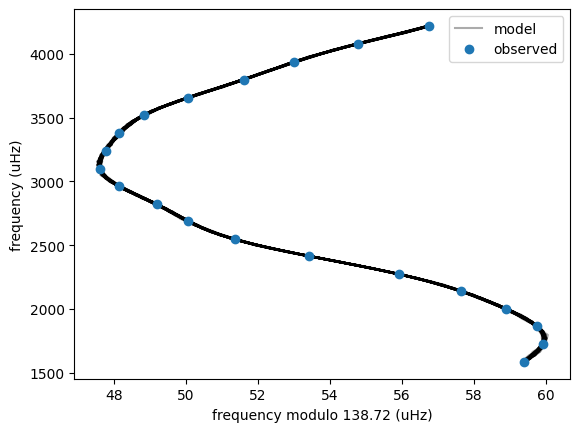

In [182]:
rng, key = random.split(rng)

ax = model.plot_echelle(key, samples["posterior"], n=n_pred, nu=nu)

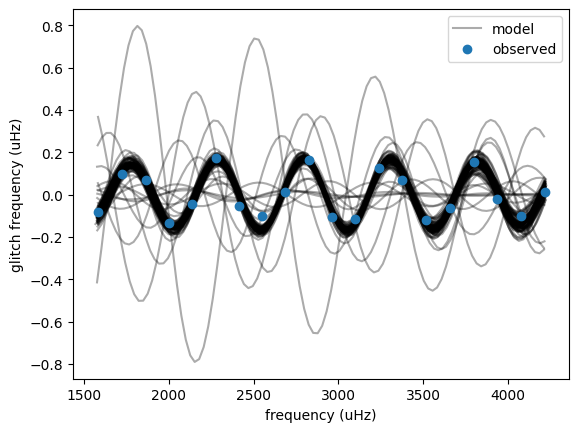

In [183]:
rng, key = random.split(rng)
ax = model.plot_glitch(key, samples["posterior"], n=n_pred, nu=nu)

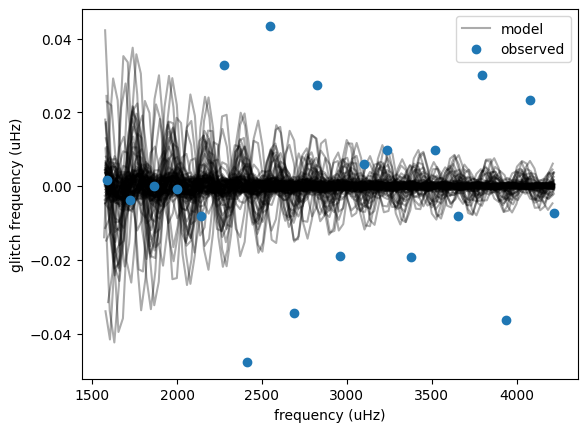

In [184]:
rng, key = random.split(rng)
ax = model.plot_glitch(key, samples["posterior"], n=n_pred, nu=nu, kind="cz")

In [85]:
import arviz as az

In [ ]:
const_data = {"nu_err": nu_err}

data = az.from_dict(
    **jax.tree_map(lambda x: jnp.expand_dims(x, axis=0), samples),
    constant_data=const_data,
)
data

In [ ]:
log_samples = jax.tree_map(
    jnp.log10,
    {"_".join(["log", k]): v for k, v in samples["posterior"].items() if (v > 0.0).all()}
)

In [ ]:
rng, key = random.split(rng)
keys = random.split(key, num_samples)

samples["predictions"] = vmap(partial(model.predict, n=n_pred, nu=nu))(keys, samples["posterior"])

In [ ]:
data = az.from_dict(
    **jax.tree_map(lambda x: jnp.expand_dims(x, axis=0), samples),
    constant_data=const_data,
)
data

In [ ]:
def to_nparray(x):
    if x is not None:
        return np.asarray(x)

In [ ]:
np_results = jax.tree_map(to_nparray, results)
leaves, treedef = jax.tree_util.tree_flatten(np_results)

In [ ]:
np.savez_compressed("temp", leaves=np.array(leaves, dtype=object), treedef=treedef)

In [ ]:
with jnp.load("temp.npz", allow_pickle=True) as file:
    newleaves = file["leaves"]
    if type(file["treedef"].item()) == jax.tree_util.PyTreeDef:
        # must be exactly PyTreeDef type
        newtreedef = file["treedef"].item()
    else:
        raise IOError("Item 'treedef' is not of type 'jax.tree_util.PyTreeDef'.")

In [5]:
def to_jaxarray(x):
    if x is not None:
        return jnp.asarray(x)

loaded_results = jax.tree_map(to_jaxarray, jax.tree_util.tree_unflatten(newtreedef, newleaves))

In [7]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)
samples = jaxns.resample(key, loaded_results.samples, loaded_results.log_dp_mean, S=int(loaded_results.ESS), replace=True)

In [8]:
samples

{'a_cz': DeviceArray([102043.5 , 137791.9 ,  44777.42, ..., 107405.82, 128018.2 ,
              100766.78], dtype=float32),
 'a_he': DeviceArray([0.00754525, 0.00266086, 0.01584811, ..., 0.01552501,
              0.00872359, 0.01043842], dtype=float32),
 'b_he': DeviceArray([1.6187032e-06, 9.9234364e-07, 2.0777586e-06, ...,
              1.9988640e-06, 1.6488766e-06, 1.8054237e-06], dtype=float32),
 'delta_nu': DeviceArray([81.83157 , 81.728836, 81.66449 , ..., 81.997734, 81.9366  ,
              81.84556 ], dtype=float32),
 'epsilon': DeviceArray([1.3339782, 1.3508258, 1.4053029, ..., 1.299796 , 1.3209319,
              1.3480508], dtype=float32),
 'kernel_amp': DeviceArray([19.354883, 20.847286, 19.763044, ..., 13.001242, 11.569484,
              19.623999], dtype=float32),
 'kernel_scale': DeviceArray([3.7756522, 4.0700865, 3.6809835, ..., 3.4062152, 3.6264489,
              3.5756886], dtype=float32),
 'phi_cz': DeviceArray([ 2.6365554 , -2.0249784 ,  0.49431145, ...,  3.048458  ,


In [53]:
loaded_results.total_num_likelihood_evaluations

DeviceArray(5525415, dtype=int32)

gp = GP(kernel, n, mean=dnu*(n + eps))
nu = gp.sample() or just nu_obs <-- this is an observed param
dnu = glitch(nu)
gp.log_prob(nu_obs - )